In [1]:
from pyspark.sql import SparkSession
import os
os.environ['GROUP_ID'] = 'g_teg_ams_exp_ams_exp_report'
os.environ['GAIA_ID'] = '3122'
session = SparkSession.builder.config('spark.driver.memory', '8g').config('spark.executor.cores', 8).config('spark.executor.memory', '8g').getOrCreate()

Driver Log: c642d82b-869e-467f-95f8-e3c4e03cabcb.log
Tracking URL: http://application.tdw.oa.com:8080/proxy/application_1651128848533_19062726


In [35]:
import numpy as np
import os
import pandas as pd
import math
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math

expId=62206
beginDate='20220901'
endDate='20220901'
dateRange=[d.strftime('p_%Y%m%d') for d in pd.date_range(beginDate,endDate)]
print(dateRange)

['p_20220901']


In [36]:
from pytoolkit import TDWSQLProvider
provider = TDWSQLProvider(session, group='tl', db='teg_ams_exp_report_app')
provider.table('t_exp_trigger_mh_d', priParts=dateRange).createOrReplaceTempView('t_exp_trigger_mh_d')

In [37]:
sqlString="""select partition_time,adgroup_id,advertiser_id,
       sum(real_cost_micro_with_contract)/1000000 as cost,
       sum(gmv)/1000000 as gmv,
       sum(valid_exposure_count) as imp,
       sum(valid_click_count) as clk,
       sum(first_conv_count) as conv
from t_exp_trigger_mh_d
where partition_time between {} and {}
       and exp_id in ({})
       and abnormal_user_type in (0)
group by partition_time,adgroup_id,advertiser_id""".format(
    beginDate,endDate,
    expId
)
print(sqlString)

select partition_time,adgroup_id,advertiser_id,
       sum(real_cost_micro_with_contract)/1000000 as cost,
       sum(gmv)/1000000 as gmv,
       sum(valid_exposure_count) as imp,
       sum(valid_click_count) as clk,
       sum(first_conv_count) as conv
from t_exp_trigger_mh_d
where partition_time between 20220901 and 20220901
       and exp_id in (62206)
       and abnormal_user_type in (0)
group by partition_time,adgroup_id,advertiser_id


In [38]:
df=session.sql(sqlString).toPandas()

In [39]:
df

,partition_time,adgroup_id,advertiser_id,cost,gmv,imp,clk,conv
0,20220901,6450312550,25600486,0.00,0.0,2,0,0
1,20220901,6456479609,24044379,42.55,115.8,1527,19,1
2,20220901,6437741927,25379081,0.07,0.0,13,0,0
3,20220901,6444126093,24839784,1.29,0.0,17,1,0
4,20220901,6301761412,25537082,0.00,0.0,2,0,0
...,...,...,...,...,...,...,...,...
3259900,20220901,6461980880,24880307,0.00,0.0,3,0,0
3259901,20220901,6461088281,24962687,0.00,0.0,0,0,0
3259902,20220901,6462231567,25670672,6.68,0.0,487,30,0
3259903,20220901,6465268807,21054149,27.98,0.0,455,4,0


In [53]:
def Zipf_Law_top(df, rank):
    df2 = df[df.cost>0]
    df3 = df2.nlargest(n=rank, columns=['cost'])
    df3['cost'] = np.log(df3['cost']) 
    df4 = df3[df3.cost<200]

    id = [i for i in range(1,len(df4)+1)]
    df4['id'] = id
    df4['id'] = np.log(df4['id']) 
    
    x = np.array([i for i in df4.id])
    y = np.array([i for i in df4.cost])
    
    reg = LinearRegression().fit(x.reshape(-1,1),y)
    abline_values = [reg.coef_ * i + reg.intercept_ for i in df4.id]
    diabetes_y_pred = reg.predict(x.reshape(-1,1))

    df4.plot.scatter(x = 'id',y = 'cost')
    plt.plot(x, diabetes_y_pred, 'b')
    plt.title("Top rank")
    print("Intercept: ",reg.intercept_)
    print("Coefficients: ", reg.coef_)
    print("r2: %.4f" % r2_score(y, diabetes_y_pred))


In [49]:
def Zipf_Law_All(df):
    df2 = df[df.cost>0]
    df5 = df2.nlargest(n=len(df2)  , columns=['cost'])
    id = [i for i in range(1,len(df5)+1)]
    df5['id'] = id
    
    cost_y = np.array([i for i in df5.cost])
    id_list = [i for i in range(1,11)]
    id_log = np.log(id_list) 
    
    value_list = []
    sum_value = 0
    for i in range(len(df5) ):
        sum_value += cost_y[i]
        if i%(len(df5)//10) == 0:
            value_list.append(sum_value)
            sum_value = 0
    #value_list.append(sum_value)
    value_list.pop(0)
    value_list = np.log(value_list) 

    x2 = np.array(id_list)
    y2 = np.array(value_list)
    reg2 = LinearRegression().fit(x2.reshape(-1,1),y2)
    
    abline_values2 = [reg2.coef_ * i + reg2.intercept_ for i in x2]
    diabetes_y_pred2 = reg2.predict(x2.reshape(-1,1))

    plt.scatter(x2,y2 )
    plt.plot(x2, diabetes_y_pred2)
    plt.title("All AD")
    print("Intercept: ", reg2.intercept_ )
    print("Coefficients: ", reg2.coef_)
    print("r2: %.4f" % r2_score(y2, diabetes_y_pred2))


Intercept:  13.704119345653755
Coefficients:  [-0.55897745]
r2: 0.9920


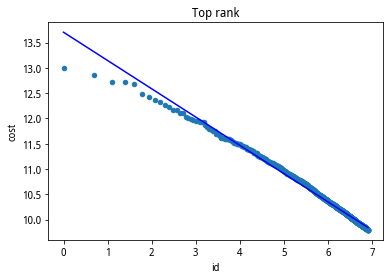

In [54]:
Zipf_Law_top(df, 1000)

Intercept:  18.599724870141863
Coefficients:  [-1.0553427]
r2: 0.9624


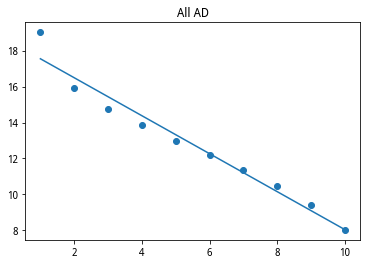

In [43]:
Zipf_Law_All(df)